In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"


import sys
from optparse import OptionParser
import pickle
from copy import deepcopy
from multiprocessing import Pool


from dynesty import NestedSampler
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc


import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

plt.rcParams['xtick.labelsize']= 12
plt.rcParams['ytick.labelsize']= 12
plt.rcParams['font.size']= 12

import pickle
import json

from plotbin.plot_velfield import plot_velfield
from plotbin.symmetrize_velfield import symmetrize_velfield
from jampy.mge_radial_density import mge_radial_density
from jampy.mge_radial_mass import mge_radial_mass
from jampy.mge_half_light_isophote import mge_half_light_isophote
from astropy import units as u

import autolens as al
import autolens.plot as aplt

from util import quantities2D, quantities3D
from dyLens.utils.tools import effective_einstein_radius_from_kappa, mge_radial_mass2d
from dyLens.Combined import updt_model

from IPython.display import display, Math

In [2]:
phase_name    = "phase5"   # phase to compute the results
result_path   = "./8/model1/"  #path to the non-linear results
data_path     = "/home/carlos//Documents/GitHub/my_illustris/TNG50-1-snap84-subhalo8/" #path to the data

In [3]:
with open(result_path+'/shear/dyLens/{}/Final_sampler_{}.pickle'.format(phase_name,phase_name),'rb') as f:
    sampler = pickle.load(f)
    f.close()
    try:
        sampler_dyLens = sampler["sampler"]
    except:
        sampler_dyLens = sampler

with open(result_path+'/shear/dyLens/{}/{}.pickle'.format(phase_name,phase_name),'rb') as f:
    phase_dyLens = pickle.load(f)
    f.close()

with open(result_path+'/shear/Lens/{}/Final_sampler_{}.pickle'.format(phase_name,phase_name),'rb') as f:
    sampler = pickle.load(f)
    f.close()
    try:
        sampler_Lens = sampler["sampler"]
    except:
        sampler_Lens = sampler

with open(result_path+'/shear/Lens/{}/{}.pickle'.format(phase_name,phase_name),'rb') as f:
    phase_Lens = pickle.load(f)
    f.close()
    

with open(result_path+f'/JAM/JAM_class.pickle','rb') as f:
    Jam_model = pickle.load(f)
    f.close()
with open(result_path+'JAM/Final_sampler.pickle','rb') as f:
    sampler = pickle.load(f)
    f.close()

In [4]:
fancy_labels = {
            "ml"   :    r"$\Upsilon$",
            "ml0"  :    r"$\Upsilon_{0}$",
            "delta":    r"$\delta$",
            "lower":    r"$\upsilon$",
            "beta" :    r"$\beta_{z}$",
            "inc"  :    r"$i$",
            "log_mbh":  r"$\log_{10}M_{\text{bh}}$",
            "log_rho_s":r"$\log_{10}\rho_{s}$",
            "log_M0":   r"$\log_{10}M_{0}$",
            "rc"    :   r"$r_{c}$",
            "rs"    :   r"$r_{s}$",
            "qDM"   :   r"$q_{\text{DM}}$",
            "slope" :   r"$\gamma$",
            "mag_shear":r"$\Gamma$",
            "phi_shear":r"$\Gamma_{\theta}$",
            "gamma":    r"$\eta$"    
}

In [5]:
p = {'inc': 80.07124180405178,
 'beta': -1.01758594781085654,
 'ml': 2.900,
 'log_rho_s': -1.0590240150357852,
 'rs': 2.036695570482836,
 'qDM': 1.0,
 'slope': 0.8022316254334987,
 'mag_shear': 0.016736318862731858,
 'phi_shear': 97.46685364507691,
 'gamma': 1.0}

In [12]:
from abc import ABC, abstractmethod

class AbstractFiducial(ABC):
    def __init__(self):
        
        parsRes = self.parsFiducial.copy()  # Parameters median values
        for k, v in parsRes.items():
            parsRes[k] = float(v[1])
        
        if self.phase: # dyLens or Lens
            self.phase.CombinedModel.quiet = True
            self.Fiducial_source_galaxy(parsRes)                   # Update source galaxy model
            self.phase.CombinedModel.Updt_Model(parsRes)           # Update parameters
            _ = self.phase.CombinedModel.run_current(quiet=True)   # Update model
        
        else: # Jampy
            self.Jampy_model.Updt_Model(UpdtparsDic=parsRes)         # Update parameters
            _ = self.Jampy_model.run_current(plot=False, quiet=True) # Update model
            
        
    def Fiducial_source_galaxy(self, parsRes):
        phase_name = self.phase.phase_name
        
        if phase_name == "phase1":
            source_ell_comp = al.convert.elliptical_comps_from(
                                        axis_ratio=parsRes["source_q"], 
                                        angle=parsRes["source_phi"]
                                                              )

            source_model = al.Galaxy(
                redshift=self.phase.CombinedModel.Lens_model.z_s,
                light=al.lp.EllSersic(
                    centre=(parsRes["source_y0"],parsRes["source_x0"]),
                    elliptical_comps=source_ell_comp,
                    intensity=parsRes["source_intensity"],
                    effective_radius=parsRes["source_eff_r"],
                    sersic_index=parsRes["source_n_index"],
                ),
            )    


        else:

            adp_pix = self.phase.source_pix(
                                        pixels=int(self.phase.parsSource["pixels"]),
                                        weight_floor=self.phase.parsSource["weight_floor"],
                                        weight_power=self.phase.parsSource["weight_power"]
                                        )

            adp_reg = self.phase.source_reg(
                    inner_coefficient=self.phase.parsSource["inner_coefficient"],
                    outer_coefficient=self.phase.parsSource["outer_coefficient"],
                    signal_scale=self.phase.parsSource["signal_scale"]
                                        )

            source_model = al.Galaxy(
                                    redshift=self.phase.CombinedModel.Lens_model.z_s,
                                    pixelization=adp_pix, regularization=adp_reg,
                                    hyper_model_image=self.phase.hyper_image_2d,
                                    hyper_galaxy_image=self.phase.hyper_image_2d,
                                    )
            
            # Setting the source galaxy model
        self.phase.CombinedModel.source_galaxy(source_model=source_model) 
            
                       
    def LensFiducial(self, save_path=None):
        """
        Computes the lens fiducial model, based on the fiducial parameters, i.e.,
        parameters at quantile 0.5.

        Optional:
        -------------
        save_path: str
            A path to save the figure
        """
        if self.Jampy_model:
            raise ValueError("Jampy model doesn't constrain lensing data.")

        print("Generating lensing results. This could take a while.")
            # Config. Pyautolens plots
        cmap = aplt.Cmap(cmap="rainbow")
        
        if save_path:
            mat_plot_2d_output = aplt.MatPlot2D(
                        output=aplt.Output(
                            filename=f"None",
                            path=save_path,
                            format=["png",],
                            format_folder=True,
                        ),
                        cmap=cmap)
        else:
            mat_plot_2d_output = aplt.MatPlot2D(cmap=cmap)
            
        mat_plot_2d =  mat_plot_2d_output
            
            # Make a fit plotter
        fit_plotter = aplt.FitImagingPlotter(fit=self.phase.CombinedModel.Fit, 
                                             mat_plot_2d=mat_plot_2d
                                            )

        mat_plot_2d.output.filename = "fit_subplot"
        fit_plotter.subplot_fit_imaging()

        mat_plot_2d.output.filename = "fit_image"
        fit_plotter.figures_2d(image=True)

        mat_plot_2d.output.filename = "fit_model"
        fit_plotter.figures_2d(model_image=True)

        mat_plot_2d.output.filename = "residual"
        fit_plotter.figures_2d(residual_map=True)

        mat_plot_2d.output.filename = "subplot_plane"
        fit_plotter.subplot_of_planes(plane_index=1)

        if phase_name == "phase1":
            pass
        else:
            # Make a inversion plotter
            inversion_plotter = aplt.InversionPlotter(
                                            inversion=self.phase.CombinedModel.Fit.inversion, 
                                            mat_plot_2d=mat_plot_2d)

            mat_plot_2d.output.filename = "reconstruction"
            inversion_plotter.figures_2d_of_mapper(mapper_index=0,
                            reconstruction=True)

            mat_plot_2d.output.filename = "subplot_inversion"
            inversion_plotter.subplot_of_mapper(mapper_index=0)
    
    def DynFiducial(self, save_path=None):
        """
        Computes the dynamical fiducial model, based on the fiducial parameters, i.e.,
        parameters at quantile 0.5.

        Optional:
        -------------
        save_path: str
            A path to save the figure
        """
        if self.Lens_phase:
            raise ValueError("Lens model only doesn't constrain dynamical data.")
            
        if self.phase:
            Jampy_model = self.phase.CombinedModel.Jampy_model
            rmsModel, ml, chi2, chi2T = Jampy_model._run(plot=False, quiet=True)
            
        else:
            Jampy_model = self.Jampy_model
            rmsModel, ml, chi2, flux  = self.Jampy_model.run_current(plot=False, quiet=True)
            
        
        
        
        sym = symmetrize_velfield(xbin=Jampy_model.xbin,
                          ybin=Jampy_model.ybin,
                          vel_bin=Jampy_model.rms)

        plt.figure(figsize=(18,10))
        plt.subplot(221)
        plot_velfield(x=Jampy_model.xbin,
                      y=Jampy_model.ybin,
                      vel=Jampy_model.rms, 
                      colorbar=True,label='km/s',
                      cmap="rainbow", markersize=2)
        plt.title(r"Input $V_{\rm rms}$")
        plt.xlabel("x (arcsec)")
        plt.ylabel("y (arcsec)")

        plt.subplot(222)
        plot_velfield(x=Jampy_model.xbin,
                      y=Jampy_model.ybin,
                      vel=sym, 
                      colorbar=True,label='km/s',
                      cmap="rainbow",markersize=2)
        plt.title(r"Symmetrized Input")
        plt.xlabel("x (arcsec)")
        plt.ylabel("y (arcsec)")

        plt.subplot(223)
        plot_velfield(x=Jampy_model.xbin,
                      y=Jampy_model.ybin,
                      vel=rmsModel, 
                      colorbar=True,label='km/s',
                      cmap="rainbow", markersize=2)
        plt.title(r"Model $V_{\rm rms}$")
        plt.xlabel("x (arcsec)")
        plt.ylabel("y (arcsec)")

        plt.subplot(224)
        residual = 100*abs(Jampy_model.rms-rmsModel)/Jampy_model.rms
        plot_velfield(x=Jampy_model.xbin, 
                      y=Jampy_model.ybin,
                      vel=residual,
                      colorbar=True, cmap="rainbow",  
                      markersize=2, label="[%]")
        plt.title(r"${\Delta V_{\rm rms}^{*}}$")
        plt.xlabel("x (arcsec)")
        plt.ylabel("y (arcsec)")

        plt.subplots_adjust(hspace = -0.85, wspace=-0.55)
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path+"/dynModel.png")
        
    def Fiducial_stellarMass3D_density(self, radii,
                                           save_path=None):
        """
        Computes the tri-dimensional stellar mass density distribution.
        For the fiducial model, ie. the median sample, computes the MGE spherically-averaged density, 
        using a wrapper for the jampy function: mge_radial_density.
        The density is given in Note 11 of
        `Cappellari et al. (2015, ApJL, 804, L21)
        <https://ui.adsabs.harvard.edu/abs/2015ApJ...804L..21C>`_

        Inputs:
        -------------
        radii[arcsec]: array or scalar
            radii in arcsec where the density will be evaluated
        Optional:
        -------------
        save_path: str
            A path to save the figure

        Output:
        -------------
        stellarMass3D_density_dist[Msun/pc3]: list
            the stellar mass 3D density distribution for each point 
            in the multidimensional space of the sampler.
            This distribution is a list with shape: (Nsamples, r.size), where:
                Nsamples: number of samples in the sampler
                r.size: number of bins where the density was evaluated
        """

        if self.Lens_phase:
            raise ValueError("Lens model only doesn't constrain 3D data.")
        
        if self.phase:
            
            surf_lum  = self.phase.CombinedModel.Lens_model.surf_lum
            sigma_lum = self.phase.CombinedModel.Lens_model.sigma_lum
            qobs_lum  = self.phase.CombinedModel.Lens_model.qobs_lum
            distance  = self.phase.CombinedModel.Jampy_model.distance
            inc       = self.phase.CombinedModel.Jampy_model.inc
            ml        = self.phase.CombinedModel.Jampy_model.ml_model
            
        else:
            
            surf_lum  = self.Jampy_model.surf_lum
            sigma_lum = self.Jampy_model.sigma_lum
            qobs_lum  = self.Jampy_model.qobs_lum
            distance  = self.Jampy_model.distance
            inc       = self.Jampy_model.inc
            ml        = self.Jampy_model.ml_model
        
        
        Fiducial_stellarMass3D_density = mge_radial_density(
                                surf_lum * ml, 
                                sigma_lum, qobs_lum,
                                inc, radii, distance)
        
        if save_path:
            p = {"distribution": Fiducial_stellarMass3D_density,
                 "radii": radii}
            with  open(save_path+"/Fiducial_stellar_density3D.pickle",'wb') as f:
                pickle.dump(p, f)
                f.close()
            
        return Fiducial_stellarMass3D_density
    
    
    def Fiducial_stellarMass_3D(self, R):
        """
        Computes the tri-dimensional stellar mass
        through the fiducial model.

        For the fiducial model computes the analytic mass
        of an axisymmetric MGE within a sphere of a given radius, 
        using a wrapper for the jampy function: mge_radial_mass.
        The mass is given by the equation (14) of
        `Mitzkus, Cappellari & Walcher, 2017, MNRAS, 464, 4789
        <https://ui.adsabs.harvard.edu/abs/2017MNRAS.464.4789M>`_

        Inputs:
        -------------
        R[arcsec]: float
            radius of the sphere in arcsec
        
        Output:
        -------------
        Mstar_3D[Msun]: 
            MGE 3D stellar mass within the spherical radius R.
            Units as Msun.
        """
        if self.Lens_phase:
            raise ValueError("Lens model only doesn't constrain 3D data.")
        
        if self.phase:
            
            surf_lum  = self.phase.CombinedModel.Lens_model.surf_lum
            sigma_lum = self.phase.CombinedModel.Lens_model.sigma_lum
            qobs_lum  = self.phase.CombinedModel.Lens_model.qobs_lum
            distance  = self.phase.CombinedModel.Jampy_model.distance
            inc       = self.phase.CombinedModel.Jampy_model.inc
            ml        = self.phase.CombinedModel.Jampy_model.ml_model
            
        else:
            
            surf_lum  = self.Jampy_model.surf_lum
            sigma_lum = self.Jampy_model.sigma_lum
            qobs_lum  = self.Jampy_model.qobs_lum
            distance  = self.Jampy_model.distance
            inc       = self.Jampy_model.inc
            ml        = self.Jampy_model.ml_model
            

        self.Fiducial_Mstar_3D = mge_radial_mass(
                                            surf_lum * ml, 
                                            sigma_lum, qobs_lum,
                                            inc, R, 
                                            distance
                                            )
        
        return self.Fiducial_Mstar_3D

    def Fiducial_stellarMass_2D(self, R):
        """
        Computes the bi-dimensional stellar mass
        through fiducial model

        For the fiducial model computes the analytic mass
        of an axisymmetric MGE within a circle of a given radius.

        Inputs:
        -------------
        R[arcsec]: float
            radius of the sphere in arcsec
        
        Output:
        -------------
        Mstar_2D[Msun]: 
            MGE 2D stellar mass within the circle radius R.
            Units as Msun.
        """
        if self.phase:
            
            surf_lum  = self.phase.CombinedModel.Lens_model.surf_lum
            sigma_lum = self.phase.CombinedModel.Lens_model.sigma_lum
            qobs_lum  = self.phase.CombinedModel.Lens_model.qobs_lum
            ml        = self.parsFiducial["ml"][1]
            if self.dyLens_phase:
                distance = self.phase.CombinedModel.Jampy_model.distance
            else: # Lens model only
                distance = self.phase.CombinedModel.cosmology.angular_diameter_distance(
                            self.phase.CombinedModel.Lens_model.z_l).value
            
        else:
            
            surf_lum  = self.Jampy_model.surf_lum
            sigma_lum = self.Jampy_model.sigma_lum
            qobs_lum  = self.Jampy_model.qobs_lum
            distance  = self.Jampy_model.distance
            ml        = self.Jampy_model.ml_model

        self.Fiducial_Mstar_2D = mge_radial_mass2d(
                                            surf_lum * ml, 
                                            sigma_lum, qobs_lum,
                                            a=np.asarray([0.0]), 
                                            b=np.asarray([R]), 
                                            distance=distance)
        return self.Fiducial_Mstar_2D
    
    def Fiducial_dmMass3D_density(self, radii,
                                    save_path=None):
        """
        Computes the tri-dimensional dark matter mass density.
        For the fiducial model computes the MGE spherically-averaged density, 
        using a wrapper for the jampy function: mge_radial_density.
        The density is given in Note 11 of
        `Cappellari et al. (2015, ApJL, 804, L21)
        <https://ui.adsabs.harvard.edu/abs/2015ApJ...804L..21C>`_


        Inputs:
        -------------
        radii[arcsec]: array or scalar
            radii where the density will be evaluated
        Optional:
        -------------
        save_path: str
            A path to save the figure

        Output:
        -------------
        Fiducial_dmMass3D_density[Msun/pc3]: list
            The dm mass 3D density for the fiducial model
        """
        
        if self.Lens_phase:
            raise ValueError("Lens model only doesn't constrain dynamical data.")

        if self.phase:
            fit_function = self.phase.CombinedModel.mgeDM.fit
            inc       = self.phase.CombinedModel.Jampy_model.inc
            distance  = self.phase.CombinedModel.Jampy_model.distance            
        else:
            fit_function = self.Jampy_model.mgeDM.fit
            inc       = self.Jampy_model.inc
            distance  = self.Jampy_model.distance
        
            # Fiducial DM parameters
        rho_s = 10 ** self.parsFiducial["log_rho_s"][1]
        r_s   = self.parsFiducial["rs"][1]
        slope = self.parsFiducial["slope"][1]
        
        surf_DM, sigma_DM = fit_function(rho_s=rho_s, r_s=r_s, slope=slope)
        qobs_DM = np.full_like(surf_DM, 1.0)
                
        Fiducial_dmMass3D_density = mge_radial_density(
                                            surf_DM, 
                                            sigma_DM, qobs_DM,
                                            inc, radii, distance)
        
        if save_path:
            p = {"distribution": Fiducial_dmMass3D_density,
                 "radii": radii}
            with  open(save_path+"/Fiducial_DM_density3D.pickle",'wb') as f:
                pickle.dump(p, f)
                f.close()
            
        return Fiducial_dmMass3D_density
    
    def Fiducial_dmMass_3D(self, R):
        """
        Computes the tri-dimensional dm mass
        through the fiducial model

        For the fiducial model computes the analytic mass
        of an axisymmetric MGE within a sphere of a given radius, 
        using a wrapper for the jampy function: mge_radial_mass.
        The mass is given by the equation (14) of
        `Mitzkus, Cappellari & Walcher, 2017, MNRAS, 464, 4789
        <https://ui.adsabs.harvard.edu/abs/2017MNRAS.464.4789M>`_

        Inputs:
        -------------
        R[arcsec]: float
            radius of the sphere in arcsec
        
        Output:
        -------------
        Mdm_3D[Msun]: 
            MGE 3D dm mass within the spherical radius R.
            Units as Msun.
        """
        if self.Lens_phase:
            raise ValueError("Lens model only doesn't constrain dynamical data.")

        if self.phase:
            fit_function = self.phase.CombinedModel.mgeDM.fit
            inc       = self.phase.CombinedModel.Jampy_model.inc
            distance  = self.phase.CombinedModel.Jampy_model.distance            
        else:
            fit_function = self.Jampy_model.mgeDM.fit
            inc       = self.Jampy_model.inc
            distance  = self.Jampy_model.distance
        
            # Fiducial DM parameters
        rho_s = 10 ** self.parsFiducial["log_rho_s"][1]
        r_s   = self.parsFiducial["rs"][1]
        slope = self.parsFiducial["slope"][1]
        
        surf_DM, sigma_DM = fit_function(rho_s=rho_s, r_s=r_s, slope=slope)
        qobs_DM = np.full_like(surf_DM, 1.0)
        
        
        
        self.Fiducial_Mdm_3D = mge_radial_mass(
                                    surf_DM, 
                                    sigma_DM, qobs_DM,
                                    inc, R, 
                                    distance
                                    )
        
        return self.Fiducial_Mdm_3D
    
    def Fiducial_dmMass_2D(self, R):
        """
        Computes the bi-dimensional dm mass
        through the fiducial model.

        For the fiducial model computes the analytic mass
        of an axisymmetric MGE within a circle of a given radius.

        Inputs:
        -------------
        R[arcsec]: float
            radius of the sphere in arcsec
    
        Output:
        -------------
        Mdm_2D[Msun]: 
            MGE 2D stellar mass within the circle radius R.
            Units as Msun.
        """
        
        if self.phase:
            fit_function = self.phase.CombinedModel.mgeDM.fit
            if self.dyLens_phase:
                distance  = self.phase.CombinedModel.Jampy_model.distance  
            else:
                distance = self.phase.CombinedModel.cosmology.angular_diameter_distance(
                            self.phase.CombinedModel.Lens_model.z_l).value
                self.phase.CombinedModel.include_DM_MGE(
                                self.phase.CombinedModel.dm_profile_name
                                )
        else:
            fit_function = self.Jampy_model.mgeDM.fit
            distance  = self.Jampy_model.distance
        
            # Fiducial DM parameters
        rho_s = 10 ** self.parsFiducial["log_rho_s"][1]
        r_s   = self.parsFiducial["rs"][1]
        slope = self.parsFiducial["slope"][1]
        
        surf_DM, sigma_DM = fit_function(rho_s=rho_s, r_s=r_s, slope=slope)
        qobs_DM = np.full_like(surf_DM, 1.0)
        

        self.Fiducial_Mdm_2D = mge_radial_mass2d(
                                            surf_DM, 
                                            sigma_DM, qobs_DM,
                                            a=np.asarray([0.0]), 
                                            b=np.asarray([R]), 
                                            distance=distance)
        

        
        return self.Fiducial_Mdm_2D

In [13]:
class Analysis(AbstractFiducial):
    def __init__(self, sampler, dyLens_phase=None, 
                                Lens_phase=None, 
                                Jampy_model=None,
                                ncores=4):

        """
        A complete class to easy handle with dyLens results.
        There's still a lot to do. For example, parse with an ML other than scalar, 
        allow different dark matter, etc.

        TODO:
        - allow different ML's beyond the scalar one
        - where we calculated DM quantities, I should make use of the qDM 
            of the sampling or the fixed one
        - there is a lot of redundant coding. Maybe I should create some external functions
        - allow different dark matter profiles
        - in LensFiducial allow all phases, not just phase1 and phase5.

        Inputs:
        -------------
        sampler: dynesty sampler
            The dynesty sampler object used for sampling

        dyLens_phase,Lens_phase: phase object
            one of the phases object in dyLens.pipelines used
            to modelling.
        
        Jampy_model: JAM object
            dyLens.JAM object used to modelling
        
        ncores: int
            number of cores used during the analysis.
        """

        if (dyLens_phase == None) and (Jampy_model == None) and (Lens_phase == None):
            raise ValueError("You must provide an object to be analysed.")
        elif (dyLens_phase and Jampy_model) or (dyLens_phase and Lens_phase) or \
                        (Jampy_model and Lens_phase):
            raise ValueError("You must provide only one object to be analysed.")
        elif dyLens_phase:
            print("Initializing dyLens analysis.")
            print("####################################\n")
            
            self.phase        = deepcopy(dyLens_phase)
            self.parsNames    = dyLens_phase.PhPriors.copy()
            self.Jampy_model  = None
            self.Lens_phase   = None
            self.dyLens_phase = True

        elif Lens_phase:
            print("Initializing Lens analysis.")
            print("####################################\n")
            
            self.phase        = deepcopy(Lens_phase)
            self.parsNames    = Lens_phase.PhPriors.copy()
            self.Jampy_model  = None
            self.dyLens_phase = None
            self.Lens_phase   = True 

        elif Jampy_model:
            print("Initializing JAM analysis.")
            print("####################################\n")
            
            self.Jampy_model  = deepcopy(Jampy_model)
            self.parsNames    = Jampy_model.Priors.copy()
            self.phase        = None
            self.dyLens_phase = None
            self.Lens_phase   = None 
        
        self.ncores = ncores
            # Computing some general results
        sampler.results.summary()
        results_sim = dyfunc.jitter_run(dyfunc.resample_run(sampler.results))
        self.samples_sim, self.weights = results_sim.samples, results_sim.importance_weights()
        self.results_sim = results_sim
        self.sampler  = deepcopy(sampler)
        self.Nsamples = self.samples_sim.shape[0]
        
        labels = []
        self.parsFiducial = self.parsQuantiles()
        
        for i, key in enumerate(self.parsNames.keys()):
            labels.append( fancy_labels[key] )
        self.labels = labels
        
        print("\nFiducial values and 68% confidence level.")
        print("==========================================")
        for i in range(sampler.npdim):
            quantiles = list( self.parsFiducial.values() )[i]
            txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
            lo, hi = np.diff(quantiles)
            txt = txt.format(quantiles[1], lo, hi, labels[i])
            display(Math(txt))
        
        super().__init__()
    def parsQuantiles(self, q=[0.16, 0.5,  0.84]):
        """
        Calculates the quantiles of the parameters.

        Optional:
        ------------
        q: list or scalar
            The list of quantiles to compute from [0., 1.]
        
        Output:
        ------------
        rst: dict
            a dict with the quantiles of the parameters
        """
            # Quantiles for each parameter
        quantiles = [dyfunc.quantile(samps, q, weights=self.weights)
                    for samps in self.samples_sim.T]            
        rst = {}
        for i, key in enumerate(self.parsNames.keys()):
            rst[key] = np.asarray( quantiles[i] )
        
        return rst
    
    def tracerPlot(self, save_path=None,  **kwargs):
        """
        Wrapper for dynesty tracer plot.

        Optional:
        -------------
        save_path: str
            A path to save the figure.
        
        **kwargs:
            any dyplot.traceplot keyword
        """
        fig, axes = dyplot.traceplot(results=self.results_sim,
                                     show_titles=True,
                                     labels=self.labels, **kwargs
                                    )
        fig.tight_layout()
        if save_path:
            plt.savefig(save_path+"/tracerPlot.png")
            
    def cornerPlot(self, save_path=None,  **kwargs):
        """
        Wrapper for dynesty coner plot.

        Optional:
        -------------
        save_path: str
            A path to save the figure.
        
        **kwargs:
            any dyplot.cornerplot keyword
        """
        cfig, caxes, = dyplot.cornerplot(self.results_sim, 
                                         smooth=0.1,
                                         show_titles=True,
                                         labels=self.labels,
                                         **kwargs
                                    )
        cfig.tight_layout()
        if save_path:
            plt.savefig(save_path+"/cornerPlot.png")
    
    def stellarMass3D_density(self, radii,
                                   save_path=None):
        """
        Computes the tri-dimensional stellar mass density distribution.
        For each sample in the chain computes the MGE spherically-averaged density, 
        using a wrapper for the jampy function: mge_radial_density.
        The density is given in Note 11 of
        `Cappellari et al. (2015, ApJL, 804, L21)
        <https://ui.adsabs.harvard.edu/abs/2015ApJ...804L..21C>`_

        Inputs:
        -------------
        radii[arcsec]: array or scalar
            radii in arcsec where the density will be evaluated
        Optional:
        -------------
        save_path: str
            A path to save the figure

        Output:
        -------------
        stellarMass3D_density_dist[Msun/pc3]: list
            the stellar mass 3D density distribution for each point 
            in the multidimensional space of the sampler.
            This distribution is a list with shape: (Nsamples, r.size), where:
                Nsamples: number of samples in the sampler
                r.size: number of bins where the density was evaluated
        """

        if self.Lens_phase:
            raise ValueError("Lens model only doesn't constrain 3D data.")
        
        if self.phase:
            surf_lum  = np.asarray ( self.Nsamples * [self.phase.CombinedModel.Lens_model.surf_lum] )
            sigma_lum = np.asarray ( self.Nsamples * [self.phase.CombinedModel.Lens_model.sigma_lum])
            qobs_lum  = np.asarray ( self.Nsamples * [self.phase.CombinedModel.Lens_model.qobs_lum] )
            distance  = self.phase.CombinedModel.Jampy_model.distance
            
        else:
            surf_lum  = np.asarray ( self.Nsamples * [self.Jampy_model.surf_lum] )
            sigma_lum = np.asarray ( self.Nsamples * [self.Jampy_model.sigma_lum])
            qobs_lum  = np.asarray ( self.Nsamples * [self.Jampy_model.qobs_lum] )
            distance  = self.Jampy_model.distance
        
        
        try:
            surf_stellar_mass_dist = self.surf_stellar_mass_dist
            
        except:
                # ml sample distribution. One ML per gaussian in surf lum
            idx_ml  = list(self.parsNames.keys()).index("ml")  # ML index
            ml_dist = np.asarray ( surf_lum.shape[1] * [self.samples_sim[:,idx_ml]] ).T
                # one surf stellar mass MGE for each ml in the sample
            surf_stellar_mass_dist      = ml_dist * surf_lum
            self.surf_stellar_mass_dist = surf_stellar_mass_dist
            
            # inc sample distribution. One inc per gaussian in surf lum
        idx_inc = list(self.parsNames.keys()).index("inc") # inc index
        inc_dist = np.asarray ( surf_lum.shape[1] * [self.samples_sim[:,idx_inc]] ).T
        
        stellarMass3D_density_dist = []
        for i in range(self.Nsamples):
            stellarMass3D_density_dist.append( mge_radial_density(
                                surf_stellar_mass_dist[i], 
                                sigma_lum[i], qobs_lum[i],
                                inc_dist[i][0], 
                                radii, distance
                                )             
                            )
        if save_path:
            p = {"distribution": stellarMass3D_density_dist,
                 "radii": radii}
            with  open(save_path+"/stellar_density3D_distribution.pickle",'wb') as f:
                pickle.dump(p, f)
                f.close()
            
        self.stellarMass3D_density_dist = stellarMass3D_density_dist
        return stellarMass3D_density_dist

    def stellarMass_3D(self, R, q=[0.16, 0.5,  0.84], save_path=None):
        """
        Computes the tri-dimensional stellar mass
        through the stellar mass distribution.

        For each sample in the chain computes the analytic mass
        of an axisymmetric MGE within a sphere of a given radius, 
        using a wrapper for the jampy function: mge_radial_mass.
        The mass is given by the equation (14) of
        `Mitzkus, Cappellari & Walcher, 2017, MNRAS, 464, 4789
        <https://ui.adsabs.harvard.edu/abs/2017MNRAS.464.4789M>`_

        We also stores the stellar mass distribution into `stellar_mass3D_dist'

        Inputs:
        -------------
        R[arcsec]: float
            radius of the sphere in arcsec
        Optional:
        -------------
        q: list or scalar
            The list of quantiles to compute from [0., 1.].
            Default is median and 1\sigma
        save_path: str
            A path to save the figure
        
        Output:
        -------------
        Mstar_3D[Msun]: 
            MGE 3D stellar mass within the spherical radius R at the input quantiles.
            Units as Msun.
        """
        if self.Lens_phase:
            raise ValueError("Lens model only doesn't constrain 3D data.")
        
        if self.phase:
            surf_lum  = np.asarray ( self.Nsamples * [self.phase.CombinedModel.Lens_model.surf_lum] )
            sigma_lum = np.asarray ( self.Nsamples * [self.phase.CombinedModel.Lens_model.sigma_lum])
            qobs_lum  = np.asarray ( self.Nsamples * [self.phase.CombinedModel.Lens_model.qobs_lum] )
            distance  = self.phase.CombinedModel.Jampy_model.distance
            
        else:
            surf_lum  = np.asarray ( self.Nsamples * [self.Jampy_model.surf_lum] )
            sigma_lum = np.asarray ( self.Nsamples * [self.Jampy_model.sigma_lum])
            qobs_lum  = np.asarray ( self.Nsamples * [self.Jampy_model.qobs_lum] )
            distance  = self.Jampy_model.distance
        
        try:
            surf_stellar_mass_dist = self.surf_stellar_mass_dist
            
        except:
                # ml sample distribution. One ML per gaussian in surf lum
            idx_ml  = list(self.parsNames.keys()).index("ml")  # ML index
            ml_dist = np.asarray ( surf_lum.shape[1] * [self.samples_sim[:,idx_ml]] ).T
                # one surf stellar mass MGE for each ml in the sample
            surf_stellar_mass_dist      = ml_dist * surf_lum
            self.surf_stellar_mass_dist = surf_stellar_mass_dist
        
            # inc sample distribution. One inc per gaussian in surf lum
        idx_inc = list(self.parsNames.keys()).index("inc") # inc index
        inc_dist = np.asarray ( surf_lum.shape[1] * [self.samples_sim[:,idx_inc]] ).T 

        R = np.asarray( [R] * self.Nsamples )

        stellar_mass3D_dist = mge_radial_mass(
                                            surf_stellar_mass_dist, 
                                            sigma_lum, qobs_lum,
                                            inc_dist, R, 
                                            distance
                                            )
        
        stellar_mass3D_dist = np.asarray( stellar_mass3D_dist )
        Mstar_3D = dyfunc.quantile(stellar_mass3D_dist, q, weights=self.weights)
        
        if save_path:
            p = {"distribution": stellar_mass3D_dist,
                 "radii": R}
            with  open(save_path+"/stellar_Mass3D_distribution.pickle",'wb') as f:
                pickle.dump(p, f)
                f.close()
        self.Mstar_3D = Mstar_3D
        self.stellar_mass3D_dist = stellar_mass3D_dist
        return Mstar_3D
    
    def stellarMass_2D(self, R, q=[0.16, 0.5,  0.84], save_path=None):
        """
        Computes the bi-dimensional dm mass
        through the stellar mass distribution.

        For each sample in the chain computes the analytic mass
        of an axisymmetric MGE within a circle of a given radius.

        We also stores the stellar mass distribution into `stellar_mass2D_dist'
        Inputs:
        -------------
        R[arcsec]: float
            radius of the sphere in arcsec
        Optional:
        -------------
        q: list or scalar
            The list of quantiles to compute from [0., 1.].
            Default is median and 1\sigma
        save_path: str
            A path to save the figure
        
        Output:
        -------------
        Mstar_2D[Msun]: 
            MGE 2D stellar mass within the circle radius R at the input quantiles.
            Units as Msun.
        """
        
        if self.phase:
            surf_lum  = np.asarray ( self.Nsamples * [self.phase.CombinedModel.Lens_model.surf_lum] )
            sigma_lum = np.asarray ( self.Nsamples * [self.phase.CombinedModel.Lens_model.sigma_lum])
            qobs_lum  = np.asarray ( self.Nsamples * [self.phase.CombinedModel.Lens_model.qobs_lum] )
            if self.dyLens_phase:
                distance = self.phase.CombinedModel.Jampy_model.distance
            else: # Lens model only
                distance = self.phase.CombinedModel.cosmology.angular_diameter_distance(
                            self.phase.CombinedModel.Lens_model.z_l).value
            
        else:
            surf_lum  = np.asarray ( self.Nsamples * [self.Jampy_model.surf_lum] )
            sigma_lum = np.asarray ( self.Nsamples * [self.Jampy_model.sigma_lum])
            qobs_lum  = np.asarray ( self.Nsamples * [self.Jampy_model.qobs_lum] )
            distance  = self.Jampy_model.distance
        
        try:
            surf_stellar_mass_dist = self.surf_stellar_mass_dist
            
        except:
                # ml sample distribution. One ML per gaussian in surf lum
            idx_ml  = list(self.parsNames.keys()).index("ml")  # ML index
            ml_dist = np.asarray ( surf_lum.shape[1] * [self.samples_sim[:,idx_ml]] ).T
                # one surf stellar mass MGE for each ml in the sample
            surf_stellar_mass_dist      = ml_dist * surf_lum
            self.surf_stellar_mass_dist = surf_stellar_mass_dist
        
        a = np.asarray( [0] * self.Nsamples )
        R = np.asarray( [R] * self.Nsamples )
        
        stellar_mass2D_dist = mge_radial_mass2d(
                                            surf_stellar_mass_dist, 
                                            sigma_lum, qobs_lum,
                                            a=a, b=R, distance=distance)
        
        stellar_mass2D_dist = np.asarray( stellar_mass2D_dist )
        Mstar_2D = dyfunc.quantile(stellar_mass2D_dist, q, weights=self.weights)
        
        if save_path:
            p = {"distribution": stellar_mass2D_dist,
                 "radii": R}
            with  open(save_path+"/stellar_Mass2D_distribution.pickle",'wb') as f:
                pickle.dump(p, f)
                f.close()
        self.Mstar_2D = Mstar_2D
        self.stellar_mass2D_dist = stellar_mass2D_dist
        
        return Mstar_2D

    def dmMass3D_density(self, radii,
                                save_path=None):
        """
        Computes the tri-dimensional dark matter mass density distribution.
        For each sample in the chain computes the MGE spherically-averaged density, 
        using a wrapper for the jampy function: mge_radial_density.
        The density is given in Note 11 of
        `Cappellari et al. (2015, ApJL, 804, L21)
        <https://ui.adsabs.harvard.edu/abs/2015ApJ...804L..21C>`_

        Generating these distributions requires parametrizing each dark matter 
        profile as MGE. That is, for each point in the sample, a different dark matter 
        profile is created, and then parametrized. This is time consuming, especially if 
        your chain is very long. Therefore, by default we parallelize this process into 4 
        cores to speed up the analysis. You can change this default by changing the parameters 
        `ncores'.

        In addition, we only compute this once and store the results in `surf_DM_mge_dist'. 
        If you run other DM analyses, they will be faster.

        Inputs:
        -------------
        radii[arcsec]: array or scalar
            radii where the density will be evaluated
        Optional:
        -------------
        save_path: str
            A path to save the figure

        Output:
        -------------
        dmMass3D_density_dist[Msun/pc3]: list
            the dm mass 3D density distribution for each point 
            in the multidimensional space of the sampler.
            This distribution is a list with shape: (Nsamples, r.size), where:
                Nsamples: number of samples in the sampler
                r.size: number of bins where the density was evaluated
        """
        if self.Lens_phase:
            raise ValueError("Lens model only doesn't constrain dynamical data.")

        print("Parametrizing all dark matter profiles in the sample "+
        "using MGE could take a while. We are using {:.0f} cores, however ".format(self.ncores)+
        "you can speed up the process by increasing this number "+
        "by changing the parameter ncores.")
        print("==========================================")
        
        if self.phase:
            fit_function = self.phase.CombinedModel.mgeDM.fit
            distance  = self.phase.CombinedModel.Jampy_model.distance            
        else:
            fit_function = self.Jampy_model.mgeDM.fit
            distance  = self.Jampy_model.distance
        
        try:
            surf_DM_mge_dist  = self.surf_DM_mge_dist
            sigma_DM_mge_dist = self.sigma_DM_mge_dist
            qobs_DM_mge_dist  = self.qobs_DM_mge_dist
        
        except:
            idx_rho_s  = list(self.parsNames.keys()).index("log_rho_s") # log_rho_s index
            idx_r_s    = list(self.parsNames.keys()).index("rs")        # rs index
            idx_slope  = list(self.parsNames.keys()).index("slope")     # slope index
            
            rho_s = 10 ** self.samples_sim[:,idx_rho_s]
            r_s   = self.samples_sim[:,idx_r_s]
            slope = self.samples_sim[:,idx_slope]
                # Disables the convergence test to ensure all MGE 
                # parameterizations have the same number of Gaussians. 
                # In practice, only a few samples should have this behaviour, 
                # and they will contribute less.
            aux   = np.full_like(slope, False)

            pars = np.vstack([rho_s, r_s, slope, aux]).T

            surf_DM_mge_dist  = []
            sigma_DM_mge_dist = []

            with Pool(self.ncores) as p:
                surf_DM_mge_dist, sigma_DM_mge_dist = zip(*p.starmap(fit_function, pars))
                p.close()
                p.join()
            surf_DM_mge_dist  = np.asarray( surf_DM_mge_dist )
            sigma_DM_mge_dist = np.asarray( sigma_DM_mge_dist )
            qobs_DM_mge_dist  = np.full_like( surf_DM_mge_dist, 1 )

            self.surf_DM_mge_dist  = surf_DM_mge_dist
            self.sigma_DM_mge_dist = sigma_DM_mge_dist
            self.qobs_DM_mge_dist  = qobs_DM_mge_dist
    
        idx_inc = list(self.parsNames.keys()).index("inc") # inc index
        inc_dist = np.asarray( surf_DM_mge_dist.shape[1] * [self.samples_sim[:,idx_inc]] ).T 
        
        dmMass3D_density_dist = []
        for i in range(self.Nsamples):
            dmMass3D_density_dist.append( mge_radial_density(
                                surf_DM_mge_dist[i], 
                                sigma_DM_mge_dist[i], qobs_DM_mge_dist[i],
                                inc_dist[i][0], 
                                radii, distance
                                )

                            )
        if save_path:
            p = {"distribution": dmMass3D_density_dist,
                 "radii": radii}
            with  open(save_path+"/dm_density3D_distribution.pickle",'wb') as f:
                pickle.dump(p, f)
                f.close()

        self.dmMass3D_density_dist = dmMass3D_density_dist

        return dmMass3D_density_dist
    
    def dmMass_3D(self, R, q=[0.16, 0.5,  0.84], save_path=None):
        """
        Computes the tri-dimensional dm mass
        through the dm mass distribution.

        For each sample in the chain computes the analytic mass
        of an axisymmetric MGE within a sphere of a given radius, 
        using a wrapper for the jampy function: mge_radial_mass.
        The mass is given by the equation (14) of
        `Mitzkus, Cappellari & Walcher, 2017, MNRAS, 464, 4789
        <https://ui.adsabs.harvard.edu/abs/2017MNRAS.464.4789M>`_

        We also stores the dm mass distribution into `dm_mass3D_dist'

        Generating these distributions requires parametrizing each dark matter 
        profile as MGE. That is, for each point in the sample, a different dark matter 
        profile is created, and then parametrized. This is time consuming, especially if 
        your chain is very long. Therefore, by default we parallelize this process into 4 
        cores to speed up the analysis. You can change this default by changing the parameters 
        `ncores'.
        
        In addition, we only compute this once and store the results in `surf_DM_mge_dist'. 
        If you run other DM analyses, they will be faster.

        Inputs:
        -------------
        R[arcsec]: float
            radius of the sphere in arcsec
        Optional:
        -------------
        q: list or scalar
            The list of quantiles to compute from [0., 1.].
            Default is median and 1\sigma
        save_path: str
            A path to save the figure
        
        Output:
        -------------
        Mdm_3D[Msun]: 
            MGE 3D dm mass within the spherical radius R at the input quantiles.
            Units as Msun.
        """
        if self.Lens_phase:
            raise ValueError("Lens model only doesn't constrain dynamical data.")

        print("Parametrizing all dark matter profiles in the sample "+
        "using MGE could take a while. We are using {:.0f} cores, however ".format(self.ncores)+
        "you can speed up the process by increasing this number "+
        "by changing the parameter ncores.")
        print("==========================================")

        if self.phase:
            fit_function = self.phase.CombinedModel.mgeDM.fit
            distance  = self.phase.CombinedModel.Jampy_model.distance            
        else:
            fit_function = self.Jampy_model.mgeDM.fit
            distance  = self.Jampy_model.distance
        
        try:
            surf_DM_mge_dist  = self.surf_DM_mge_dist
            sigma_DM_mge_dist = self.sigma_DM_mge_dist
            qobs_DM_mge_dist  = self.qobs_DM_mge_dist
        
        except:
            
            idx_rho_s  = list(self.parsNames.keys()).index("log_rho_s") # log_rho_s index
            idx_r_s    = list(self.parsNames.keys()).index("rs")        # rs index
            idx_slope  = list(self.parsNames.keys()).index("slope")     # slope index
            
            rho_s = 10 ** self.samples_sim[:,idx_rho_s]
            r_s   = self.samples_sim[:,idx_r_s]
            slope = self.samples_sim[:,idx_slope]
                # Disables the convergence test to ensure all MGE 
                # parameterizations have the same number of Gaussians. 
                # In practice, only a few samples should have this behaviour, 
                # and they will contribute less.
            aux   = np.full_like(slope, False)

            pars = np.vstack([rho_s, r_s, slope, aux]).T

            surf_DM_mge_dist  = []
            sigma_DM_mge_dist = []

            with Pool(self.ncores) as p:
                surf_DM_mge_dist, sigma_DM_mge_dist = zip(*p.starmap(fit_function, pars))
                p.close()
                p.join()
            surf_DM_mge_dist  = np.asarray( surf_DM_mge_dist )
            sigma_DM_mge_dist = np.asarray( sigma_DM_mge_dist )
            qobs_DM_mge_dist  = np.full_like( surf_DM_mge_dist, 1 )

            self.surf_DM_mge_dist  = surf_DM_mge_dist
            self.sigma_DM_mge_dist = sigma_DM_mge_dist
            self.qobs_DM_mge_dist  = qobs_DM_mge_dist
        
        idx_inc = list(self.parsNames.keys()).index("inc") # inc index
        inc_dist = np.asarray( surf_DM_mge_dist.shape[1] * [self.samples_sim[:,idx_inc]] ).T 
        R = np.asarray( [R] * self.Nsamples )
        dm_mass3D_dist = mge_radial_mass(
                                    surf_DM_mge_dist, 
                                    sigma_DM_mge_dist, qobs_DM_mge_dist,
                                    inc_dist, R, 
                                    distance
                                    )
        dm_mass3D_dist = np.asarray( dm_mass3D_dist )
        Mdm_3D = dyfunc.quantile(dm_mass3D_dist, q, weights=self.weights)
        
        if save_path:
            p = {"distribution": dm_mass3D_dist,
                 "radii": R}
            with  open(save_path+"/dm_Mass3D_distribution.pickle",'wb') as f:
                pickle.dump(p, f)
                f.close()
        
        self.Mdm_3D = Mdm_3D
        self.dm_mass3D_dist = dm_mass3D_dist
        return Mdm_3D
    
    def dmMass_2D(self, R, q=[0.16, 0.5,  0.84], save_path=None):
        """
        Computes the bi-dimensional dm mass
        through the stellar mass distribution.

        For each sample in the chain computes the analytic mass
        of an axisymmetric MGE within a circle of a given radius.

        We also stores the stellar mass distribution into `dm_mass2D_dist'
        
        Generating these distributions requires parametrizing each dark matter 
        profile as MGE. That is, for each point in the sample, a different dark matter 
        profile is created, and then parametrized. This is time consuming, especially if 
        your chain is very long. Therefore, by default we parallelize this process into 4 
        cores to speed up the analysis. You can change this default by changing the parameters 
        `ncores'.
        
        In addition, we only compute this once and store the results in `surf_DM_mge_dist'. 
        If you run other DM analyses, they will be faster.

        Inputs:
        -------------
        R[arcsec]: float
            radius of the sphere in arcsec
        Optional:
        -------------
        q: list or scalar
            The list of quantiles to compute from [0., 1.].
            Default is median and 1\sigma
        save_path: str
            A path to save the figure
        
        Output:
        -------------
        Mdm_2D[Msun]: 
            MGE 2D stellar mass within the circle radius R at the input quantiles.
            Units as Msun.
        """

        print("Parametrizing all dark matter profiles in the sample "+
        "using MGE could take a while. We are using {:.0f} cores, however ".format(self.ncores)+
        "you can speed up the process by increasing this number "+
        "by changing the parameter ncores.")
        print("==========================================")

        if self.phase:
            if self.dyLens_phase:

                fit_function = self.phase.CombinedModel.mgeDM.fit
                distance  = self.phase.CombinedModel.Jampy_model.distance  
            else: # Just lens model
                self.phase.CombinedModel.include_DM_MGE(
                                self.phase.CombinedModel.dm_profile_name
                                )
                fit_function = self.phase.CombinedModel.mgeDM.fit
                distance = self.phase.CombinedModel.cosmology.angular_diameter_distance(
                            self.phase.CombinedModel.Lens_model.z_l).value

        else:
            fit_function = self.Jampy_model.mgeDM.fit
            distance  = self.Jampy_model.distance
        
        try:
            surf_DM_mge_dist  = self.surf_DM_mge_dist
            sigma_DM_mge_dist = self.sigma_DM_mge_dist
            qobs_DM_mge_dist  = self.qobs_DM_mge_dist
        
        except:
            
            idx_rho_s  = list(self.parsNames.keys()).index("log_rho_s") # log_rho_s index
            idx_r_s    = list(self.parsNames.keys()).index("rs")        # rs index
            idx_slope  = list(self.parsNames.keys()).index("slope")     # slope index
            
            rho_s = 10 ** self.samples_sim[:,idx_rho_s]
            r_s   = self.samples_sim[:,idx_r_s]
            slope = self.samples_sim[:,idx_slope]
                # Disables the convergence test to ensure all MGE 
                # parameterizations have the same number of Gaussians. 
                # In practice, only a few samples should have this behaviour, 
                # and they will contribute less.
            aux   = np.full_like(slope, False)

            pars = np.vstack([rho_s, r_s, slope, aux]).T

            surf_DM_mge_dist  = []
            sigma_DM_mge_dist = []

            with Pool(self.ncores) as p:
                surf_DM_mge_dist, sigma_DM_mge_dist = zip(*p.starmap(fit_function, pars))
                p.close()
                p.join()
            surf_DM_mge_dist  = np.asarray( surf_DM_mge_dist )
            sigma_DM_mge_dist = np.asarray( sigma_DM_mge_dist )
            qobs_DM_mge_dist  = np.full_like( surf_DM_mge_dist, 1 )

            self.surf_DM_mge_dist  = surf_DM_mge_dist
            self.sigma_DM_mge_dist = sigma_DM_mge_dist
            self.qobs_DM_mge_dist  = qobs_DM_mge_dist
        
        a = np.asarray( [0] * self.Nsamples )
        R = np.asarray( [R] * self.Nsamples )
        
        dm_mass2D_dist = mge_radial_mass2d(
                                        surf_DM_mge_dist, 
                                        sigma_DM_mge_dist, qobs_DM_mge_dist,
                                        a=a, b=R, distance=distance)
        
        dm_mass2D_dist = np.asarray( dm_mass2D_dist )
        Mdm_2D = dyfunc.quantile(dm_mass2D_dist, q, weights=self.weights)
        
        if save_path:
            p = {"distribution": dm_mass2D_dist,
                 "radii": R}
            with  open(save_path+"/dm_Mass2D_distribution.pickle",'wb') as f:
                pickle.dump(p, f)
                f.close()
        self.Mdm_2D = Mdm_2D
        self.dm_mass2D_dist = dm_mass2D_dist
        
        return Mdm_2D

In [14]:
c = Analysis(sampler=sampler_Lens, Lens_phase=phase_Lens, ncores=8)

Initializing Lens analysis.
####################################

Summary
nlive: 500
niter: 8637
ncall: 124915
eff(%):  7.315
logz: 5547.950 +/-  0.191

Fiducial values and 68% confidence level.


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Parameters Updated!


In [15]:
c.Fiducial_stellarMass_2D(R=1.3618855704163977)

array([3.30366113e+10])

In [11]:
c.parsFiducial["ml"][1]

2.304273663023688

In [17]:
(10**10.67090916452487 - 4.06755567e+10)/10**10.67090916452487

0.13219061800131848

In [14]:
# Load DM density profile
pc       = c.phase.CombinedModel.Jampy_model.distance*np.pi/0.648  # Constant factor to convert arcsec --> pc
#pc       = c.Jampy_model.distance*np.pi/0.648  # Constant factor to convert arcsec --> pc


reff_pc  = 0.544754228166559*pc

    # Load DM density profile
dm_hdu = fits.open(data_path+"/dm/density_fit.fits")
rho_dm = dm_hdu[1].data["density"]
r_dm   = dm_hdu[1].data["radius"]
dm_fit = dm_hdu[1].data["bestfit"]

i = r_dm < 5*reff_pc  # Two times the max kin data
rho_dm = rho_dm[i]
r_dm   = r_dm[i]
dm_fit = dm_fit[i]

In [15]:
radii = r_dm/pc     # radii where to compute the models, in arsec
p = c.Fiducial_dmMass3D_density(radii=radii, save_path="./")

[]

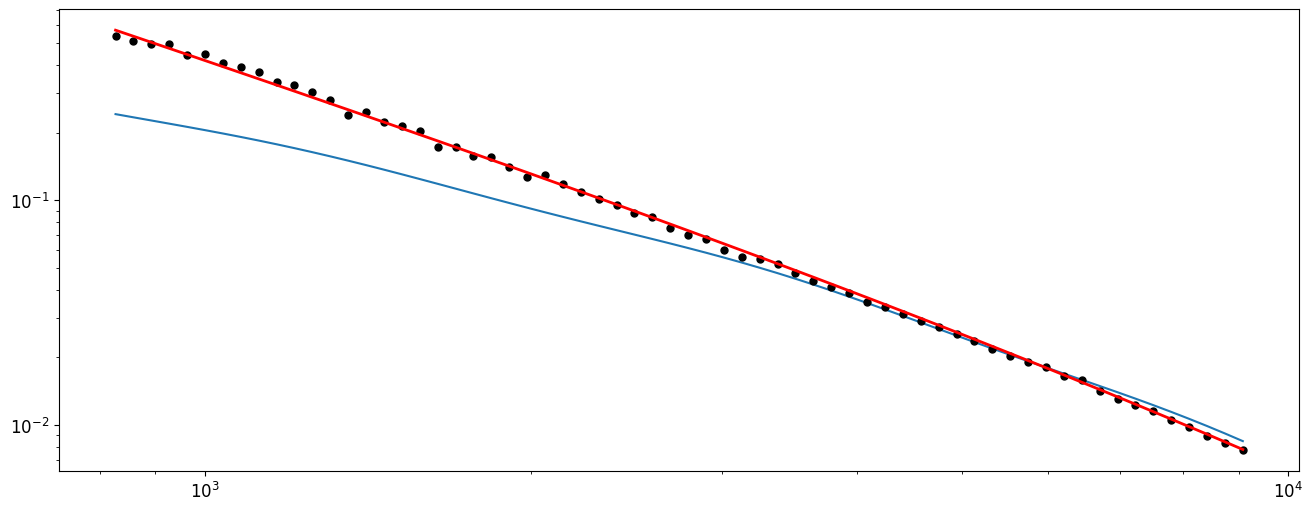

In [16]:
plt.figure(figsize=(16,6))
plt.plot(r_dm, p)
plt.plot(r_dm, rho_dm,  ".", label="True", color="black", markersize=10)
plt.plot(r_dm, dm_fit, label="Fit", color="red", linewidth=2,)



plt.loglog()

In [9]:
r = np.arange(0.1, 2.5, 0.01)
Fiducial_stellar3D_density = c.Fiducial_stellarMass3D_density(radii=r, save_path="./")

Parameters Updated!


In [14]:
c.phase.CombinedModel.run_current(quiet=True)

5246.396343885011

In [13]:
c.phase.CombinedModel.Jampy_model.inc

82.74521488504584

[]

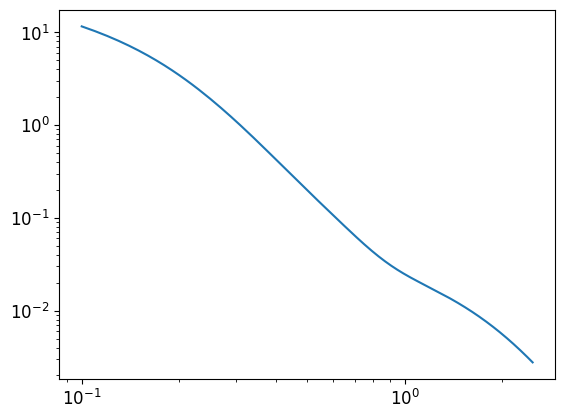

In [10]:
plt.plot(r, Fiducial_stellar3D_density)

plt.loglog()

In [11]:
dstar  = c.stellarMass3D_density(radii=r, save_path="./")

In [12]:
from scipy.stats.mstats import mquantiles


# median and 1sigma band
mean_star = mquantiles(dstar, 0.5, axis=0)[0]
lo_star   = mquantiles(dstar, 0.16, axis=0)[0]
hi_star   = mquantiles(dstar, 0.84, axis=0)[0]

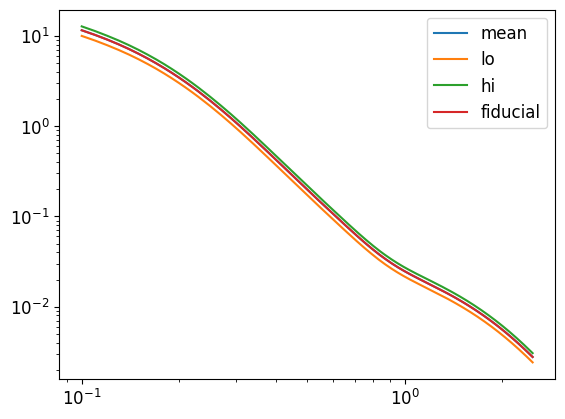

In [19]:
plt.plot(r, mean_star, label="mean")
plt.plot(r, lo_star, label="lo")
plt.plot(r, hi_star, label="hi")
plt.plot(r, Fiducial_stellar3D_density, label="fiducial")


plt.loglog()
plt.legend()

In [13]:
MMstar = c.stellarMass_3D(1.36, save_path="./")

In [9]:
MMdm   = c.dmMass_3D(1.36, save_path="./")

Parametrizing all dark matter profiles in the sample using MGE could that a while. We are using 8 cores, however you can speed up the process by increasing this number by changing the parameter ncores.


In [10]:
MMTotal_dist = c.stellar_mass3D_dist + c.dm_mass3D_dist # Total mass distribution
MMtotal = dyfunc.quantile(MMTotal_dist, 
                            q=[0.16, 0.5, 0.84],
                            weights=c.weights)
Mfdm_dist = c.dm_mass3D_dist / MMTotal_dist            # Dark matter fraction distribution
Mfdm       = dyfunc.quantile(Mfdm_dist, 
                            q=[0.16, 0.5, 0.84],
                            weights=c.weights)

In [11]:
projMMstar  = c.stellarMass_2D(R=1.36)
projMMdm    = c.dmMass_2D(R=1.36)

Parametrizing all dark matter profiles in the sample using MGE could that a while. We are using 8 cores, however you can speed up the process by increasing this number by changing the parameter ncores.


In [55]:
projMfdm_dist.shape

(4060,)

In [12]:
projMtotal_dist = c.stellar_mass2D_dist + c.dm_mass2D_dist # Total proj mass distribution
projMMtotal =  dyfunc.quantile(projMtotal_dist, 
                            q=[0.16, 0.5, 0.84],
                            weights=c.weights)

projMfdm_dist = c.dm_mass2D_dist / projMtotal_dist         # proj DM fraction distribution
projMfdm      = dyfunc.quantile(projMfdm_dist, 
                            q=[0.16, 0.5, 0.84],
                            weights=c.weights)

In [13]:
projMMtotal

[78430241514.05086, 81223286637.49792, 84840075815.08688]

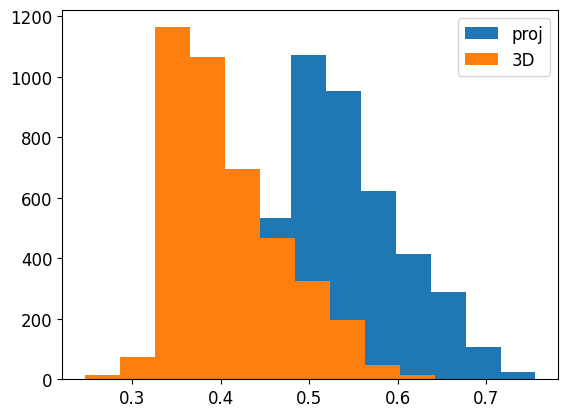

In [14]:
plt.hist(projMfdm_dist, label="proj")
plt.hist(Mfdm_dist, label="3D")

plt.legend()

In [15]:
kappa_model = c.phase.CombinedModel.Lens_model.convergence_2d_from(
                        c.phase.CombinedModel.Fit.imaging.unmasked.grid)

The analytical DM profile will be parametrized by Gaussians.


In [16]:
Re_model = effective_einstein_radius_from_kappa(
                            kappa_model, 
                            grid_spacing=c.phase.CombinedModel.Fit.image.pixel_scale,
                            grid=c.phase.CombinedModel.Fit.imaging.unmasked.grid, 
                            Nsamples=c.phase.CombinedModel.Fit.imaging.unmasked.grid.shape[0]/2)

In [17]:
Re_model

0.6365295087181563

In [18]:
stellarMass_2d = c.stellarMass_2D(R=1.3618855704163972)

In [19]:
np.log10( stellarMass_2d )

array([10.57714711, 10.60199651, 10.61573174])

In [20]:
np.diff( np.log10( stellarMass_2d ))

array([0.0248494 , 0.01373523])

In [21]:
dmMass_2d = c.dmMass_2D(R=1.3618855704163972)

Parametrizing all dark matter profiles in the sample using MGE could that a while. We are using 8 cores, however you can speed up the process by increasing this number by changing the parameter ncores.


In [22]:
np.log10( dmMass_2d )

array([10.57276981, 10.61494181, 10.67349645])

In [23]:
np.diff( np.log10( dmMass_2d ))

array([0.042172  , 0.05855465])

(array([   8.,   40.,  236., 1307., 1259.,  678.,  355.,  130.,   29.,
          18.]),
 array([10.34623591, 10.41505365, 10.4838714 , 10.55268914, 10.62150689,
        10.69032464, 10.75914238, 10.82796013, 10.89677787, 10.96559562,
        11.03441336]),
 <BarContainer object of 10 artists>)

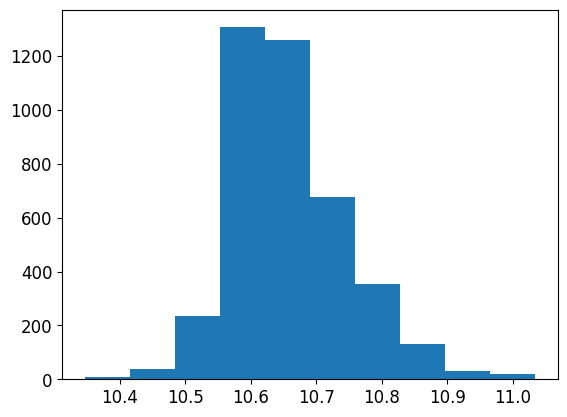

In [24]:
plt.hist(np.log10(c.dm_mass2D_dist))

In [14]:
pc       = phase.CombinedModel.Jampy_model.distance*np.pi/0.648  # Constant factor to convert arcsec --> pc

In [15]:
# Load DM density profile
dm_hdu = fits.open(data_path+"/dm/density_fit.fits")
rho_dm = dm_hdu[1].data["density"]
r_dm   = dm_hdu[1].data["radius"]
dm_fit = dm_hdu[1].data["bestfit"]


    # Load star density profile
star_hdu = fits.open(data_path+"/imgs/stellar_density.fits")
rho_star = star_hdu[1].data["density"]
r_star   = star_hdu[1].data["radius"]

radii_star = r_star/pc
radii_dm   = r_dm/pc

In [18]:
dstar  = c.stellarMass3D_density(radii=radii_star, save_path="./")

In [45]:
a = 0.2
b = 10*0.64
radii  = np.arange(a, b, 0.01)                 # Radii in arcsec
dstar  = c.stellarMass3D_density(Rmin=a, Rmax=b, save_path="./")
ddm    = c.dmMass3D_density(Rmin=a, Rmax=b, save_path="./")

dm_dist      = np.asarray(ddm)
stellar_dist = np.asarray(dstar)


dtotal = dm_dist + stellar_dist

dtotal_norm = dm_dist + stellar_dist
dtotal_norm /= np.sum(dtotal_norm)


Parametrizing all dark matter profiles in the sample using MGE could that a while. We are using 8 cores, however you can speed up the process by increasing this number by changing the parameter ncores.


In [47]:
dtotal_norm.shape, dtotal.shape

((4060, 620), (4060, 620))

In [48]:
from scipy.stats.mstats import mquantiles


# median and 1sigma band
mean_star = mquantiles(dstar, 0.5, axis=0)[0]
lo_star   = mquantiles(dstar, 0.16, axis=0)[0]
hi_star   = mquantiles(dstar, 0.84, axis=0)[0]

mean_dm = mquantiles(ddm, 0.5, axis=0)[0]
lo_dm   = mquantiles(ddm, 0.16, axis=0)[0]
hi_dm   = mquantiles(ddm, 0.84, axis=0)[0]

mean_total = mquantiles(dtotal, 0.5, axis=0)[0]
lo_total   = mquantiles(dtotal, 0.16, axis=0)[0]
hi_total   = mquantiles(dtotal, 0.84, axis=0)[0]

mean_total_N = mquantiles(dtotal_norm, 0.5, axis=0)[0]
lo_total_N   = mquantiles(dtotal_norm, 0.16, axis=0)[0]
hi_total_N   = mquantiles(dtotal_norm, 0.84, axis=0)[0]

In [49]:
pc       = phase.CombinedModel.Jampy_model.distance*np.pi/0.648  # Constant factor to convert arcsec --> pc
radii_pc = radii*pc   

In [50]:
# Load DM density profile
dm_hdu = fits.open(data_path+"/dm/density_fit.fits")
rho_dm = dm_hdu[1].data["density"]
r_dm   = dm_hdu[1].data["radius"]
dm_fit = dm_hdu[1].data["bestfit"]

i = r_dm < radii_pc.max()  # Only in the same range
rho_dm = rho_dm[i]
r_dm   = r_dm[i]
dm_fit = dm_fit[i]

    # Load star density profile
star_hdu = fits.open(data_path+"/imgs/stellar_density.fits")
rho_star = star_hdu[1].data["density"]
r_star   = star_hdu[1].data["radius"]

i = r_star < radii_pc.max() # Only in the same range
rho_star = rho_star[i]
r_star   = r_star[i]

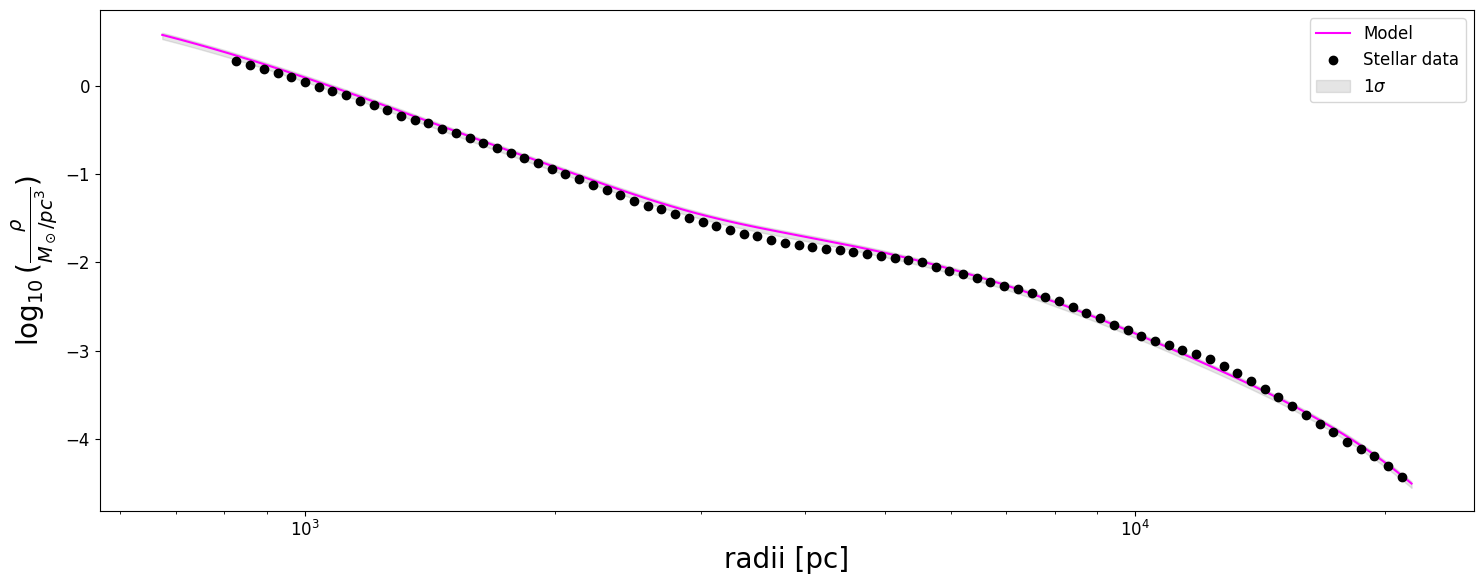

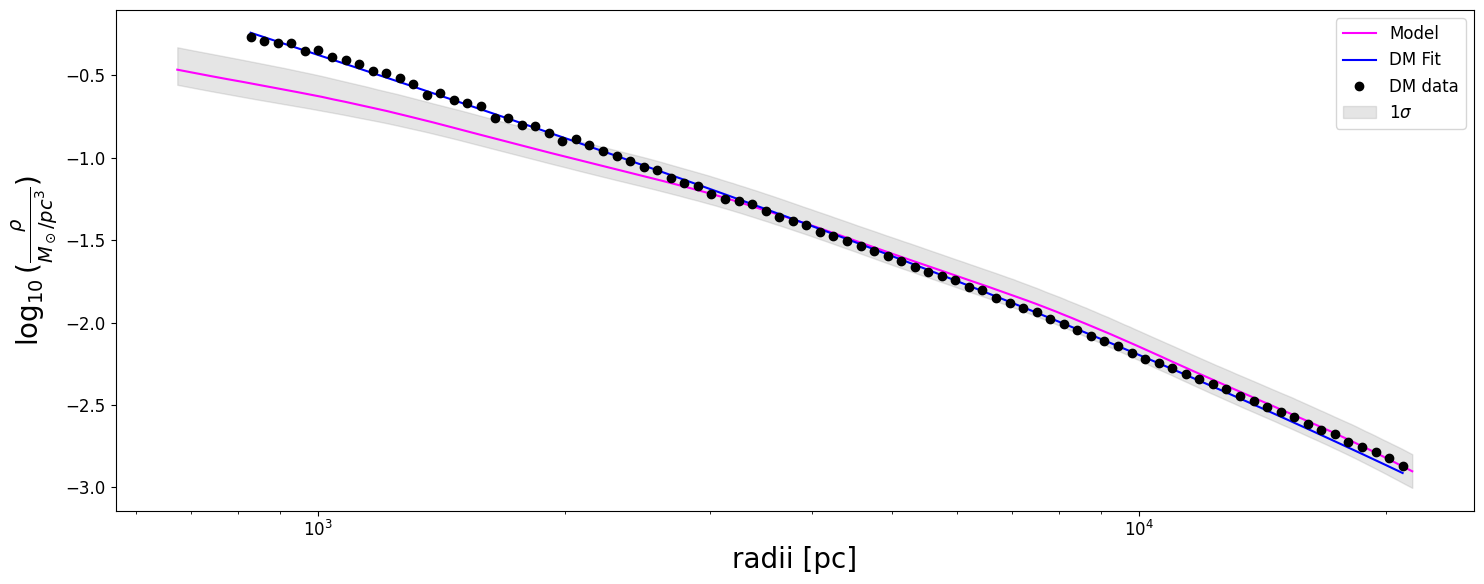

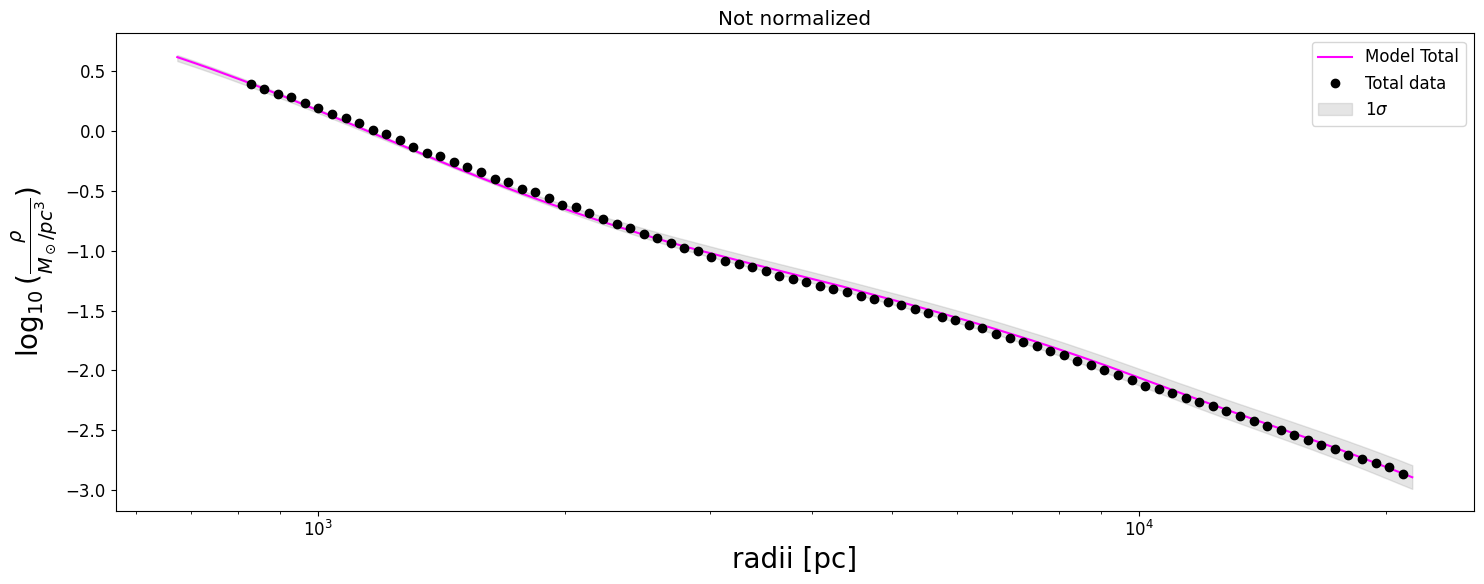

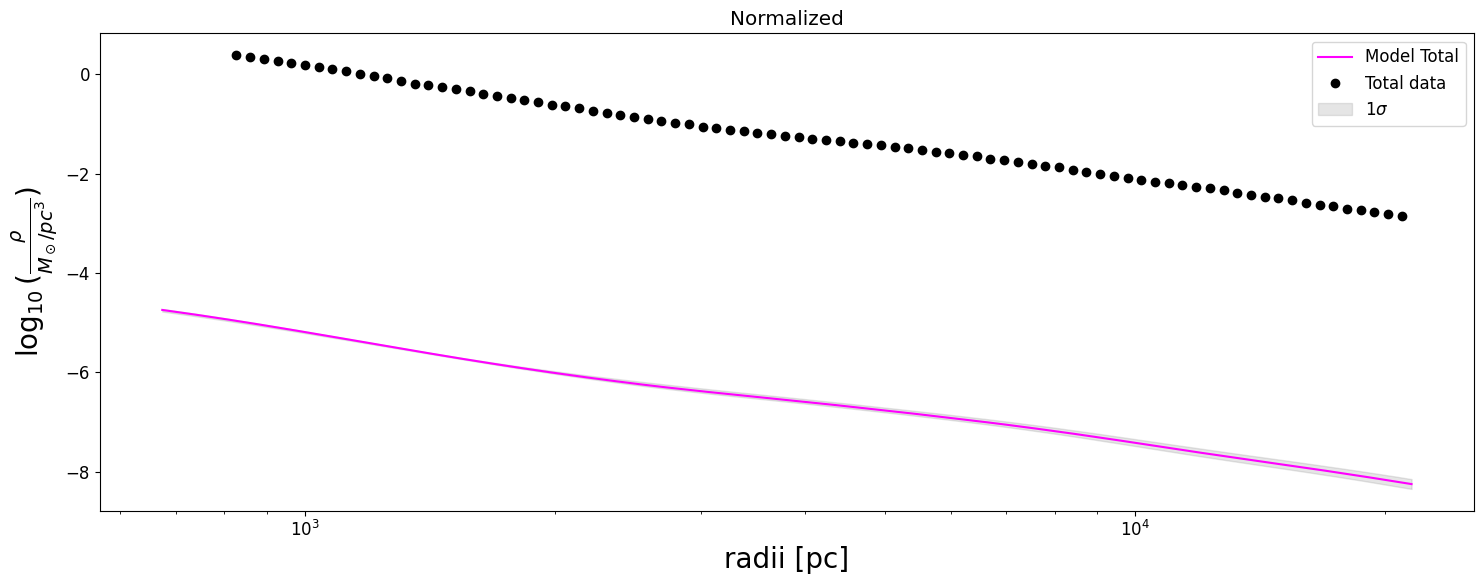

In [51]:
    # Samples equal
# Plot stellar
plt.figure(figsize=(15,6))
plt.plot(radii_pc, np.log10(mean_star), label="Model", color="magenta")
plt.plot(r_star, np.log10(rho_star),  ".", label="Stellar data", 
                        color="black", markersize=12)
plt.fill_between(radii_pc, np.log10(lo_star), np.log10(hi_star), 
                        color="gray", alpha=0.2, label="$1\sigma$")
plt.xlabel("radii [pc]", size=20)
plt.ylabel("$\log_{10}(\\frac{\\rho}{M_\odot/pc^3})$", size=20)
plt.legend()
plt.xscale("log")
plt.tight_layout()

    # Plot dm
plt.figure(figsize=(15,6))
plt.plot(radii_pc, np.log10(mean_dm), label="Model", color="magenta")
plt.plot(r_dm, np.log10(dm_fit), label="DM Fit", color="blue", markersize=12)
plt.plot(r_dm, np.log10(rho_dm),  ".", label="DM data", 
                        color="black", markersize=12)
plt.fill_between(radii_pc, np.log10(lo_dm), np.log10(hi_dm), 
                        color="gray", alpha=0.2, label="$1\sigma$")
plt.xlabel("radii [pc]", size=20)
plt.ylabel("$\log_{10}(\\frac{\\rho}{M_\odot/pc^3})$", size=20)
plt.legend()
plt.xscale("log")
plt.tight_layout()

    # Plots total
plt.figure(figsize=(15,6))
plt.title("Not normalized")
plt.plot(radii_pc, np.log10(mean_total), label="Model Total", color="magenta")
plt.plot(r_star, np.log10(rho_star + rho_dm),  ".", label="Total data", 
                        color="black", markersize=12)
plt.fill_between(radii_pc, np.log10(lo_total), np.log10(hi_total), 
                        color="gray", alpha=0.2, label="$1\sigma$")
plt.xlabel("radii [pc]", size=20)
plt.ylabel("$\log_{10}(\\frac{\\rho}{M_\odot/pc^3})$", size=20)
plt.legend()
plt.xscale("log")
plt.tight_layout()

    # Plots total
plt.figure(figsize=(15,6))
plt.title("Normalized")
plt.plot(radii_pc, np.log10(mean_total_N), label="Model Total", color="magenta")
plt.plot(r_star, np.log10(rho_star + rho_dm),  ".", label="Total data", 
                        color="black", markersize=12)
plt.fill_between(radii_pc, np.log10(lo_total_N), np.log10(hi_total_N), 
                        color="gray", alpha=0.2, label="$1\sigma$")
plt.xlabel("radii [pc]", size=20)
plt.ylabel("$\log_{10}(\\frac{\\rho}{M_\odot/pc^3})$", size=20)
plt.legend()
plt.xscale("log")
plt.tight_layout()


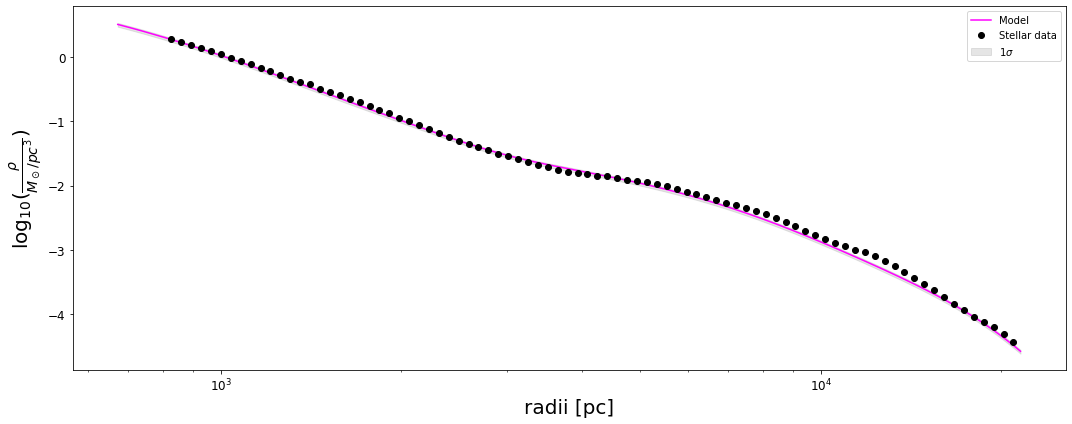

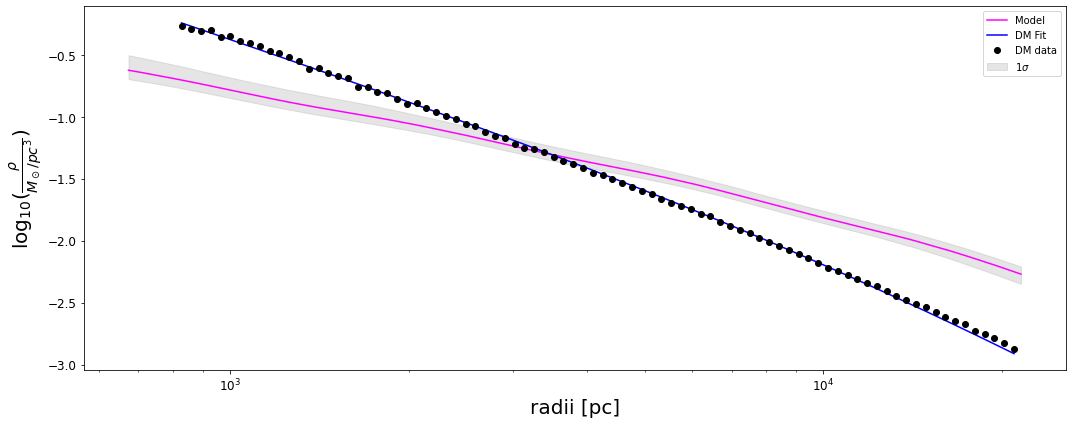

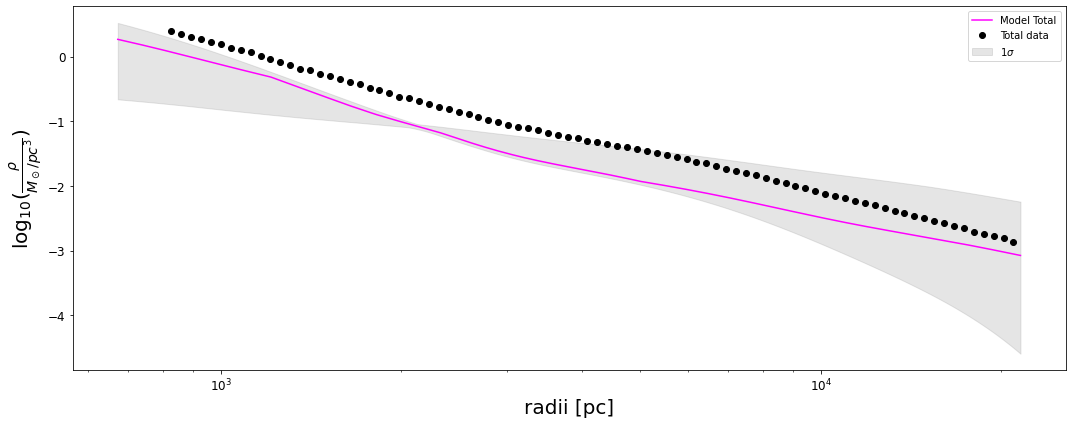

In [64]:
# Plot stellar
plt.figure(figsize=(15,6))
plt.plot(radii_pc, np.log10(mean_star), label="Model", color="magenta")
plt.plot(r_star, np.log10(rho_star),  ".", label="Stellar data", 
                        color="black", markersize=12)
plt.fill_between(radii_pc, np.log10(lo_star), np.log10(hi_star), 
                        color="gray", alpha=0.2, label="$1\sigma$")
plt.xlabel("radii [pc]", size=20)
plt.ylabel("$\log_{10}(\\frac{\\rho}{M_\odot/pc^3})$", size=20)
plt.legend()
plt.xscale("log")
plt.tight_layout()

    # Plot dm
plt.figure(figsize=(15,6))
plt.plot(radii_pc, np.log10(mean_dm), label="Model", color="magenta")
plt.plot(r_dm, np.log10(dm_fit), label="DM Fit", color="blue", markersize=12)
plt.plot(r_dm, np.log10(rho_dm),  ".", label="DM data", 
                        color="black", markersize=12)
plt.fill_between(radii_pc, np.log10(lo_dm), np.log10(hi_dm), 
                        color="gray", alpha=0.2, label="$1\sigma$")
plt.xlabel("radii [pc]", size=20)
plt.ylabel("$\log_{10}(\\frac{\\rho}{M_\odot/pc^3})$", size=20)
plt.legend()
plt.xscale("log")
plt.tight_layout()

    # Plots total
plt.figure(figsize=(15,6))
plt.plot(radii_pc, np.log10(mean_total), label="Model Total", color="magenta")
plt.plot(r_star, np.log10(rho_star + rho_dm),  ".", label="Total data", 
                        color="black", markersize=12)
plt.fill_between(radii_pc, np.log10(lo_total), np.log10(hi_total), 
                        color="gray", alpha=0.2, label="$1\sigma$")
plt.xlabel("radii [pc]", size=20)
plt.ylabel("$\log_{10}(\\frac{\\rho}{M_\odot/pc^3})$", size=20)
plt.legend()
plt.xscale("log")
plt.tight_layout()


In [27]:
dm_mass = c.dmMass_3D(R=0.6428154989273108, q=[0.025,0.50,0.975])

ValueError: Lens model only doesn't constrain dynamical data.

In [28]:
np.log10(dm_mass[1])

NameError: name 'dm_mass' is not defined

In [29]:
np.diff( np.log10(dm_mass) ) 

NameError: name 'dm_mass' is not defined

In [30]:
rst1 = c.stellarMass3D_density(save_path="./")

ValueError: Lens model only doesn't constrain 3D data.

In [31]:
from scipy.stats.mstats import mquantiles


# median and 1sigma band
mean_ = mquantiles(rst1, 0.5, axis=0)[0]
lo_   = mquantiles(rst1, 0.16, axis=0)[0]
hi_   = mquantiles(rst1, 0.84, axis=0)[0]



NameError: name 'rst1' is not defined

In [32]:
radii    = np.arange(0.25, 10, 0.01) # Radii in arcsec

pc       = phase.CombinedModel.Jampy_model.distance*np.pi/0.648  # Constant factor to convert arcsec --> pc
radii_pc = radii*pc   

In [33]:
dm_hdu = fits.open(data_path+"/imgs/stellar_density.fits")
true_density = dm_hdu[1].data["density"]
true_radii   = dm_hdu[1].data["radius"]

i = true_radii < radii_pc.max()

true_density = true_density[i]
true_radii   = true_radii[i]

NameError: name 'mean_' is not defined

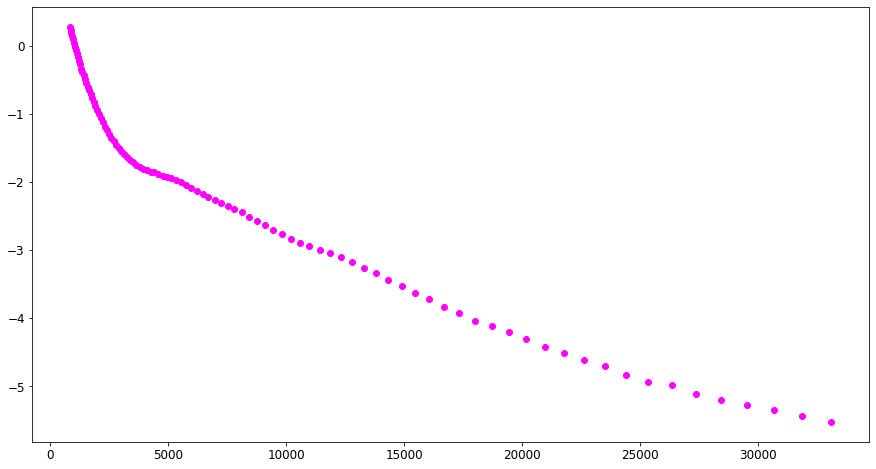

In [34]:
plt.figure(figsize=(15,8))

plt.plot(true_radii, np.log10(true_density),  ".", label="DM data", color="magenta", markersize=12)
plt.plot(radii_pc, np.log10(mean_), label="median dist")
plt.fill_between(radii_pc, np.log10(lo_), np.log10(hi_), color="gray", alpha=0.2, label="$2\sigma$")
plt.xscale("log")
plt.ylim(-2,0.5)
plt.legend()

In [32]:

with open('./dm_density3D_distribution.pickle'.format(phase_name,phase_name),'rb') as f:
    dist = pickle.load(f)
    f.close()

In [33]:
# median and 1sigma band
mean_ = mquantiles(dist, 0.5, axis=0)[0]
lo_   = mquantiles(dist, 0.16, axis=0)[0]
hi_   = mquantiles(dist, 0.84, axis=0)[0]

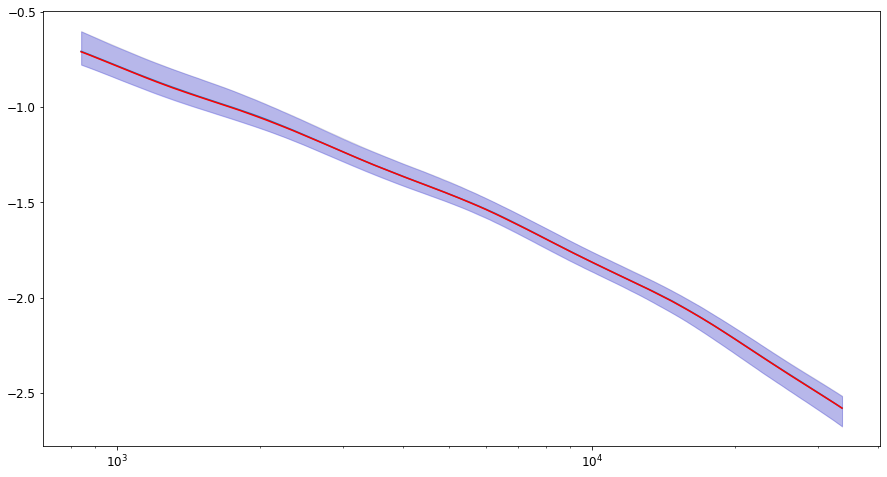

In [34]:
plt.figure(figsize=(15,8))

plt.plot(radii_pc, np.log10(mean), label="median dist")
plt.fill_between(radii_pc, np.log10(lo), np.log10(hi), color="gray", alpha=0.2, label="$2\sigma$")

plt.plot(radii_pc, np.log10(mean_), label="median_ dist", color="red")
plt.fill_between(radii_pc, np.log10(lo_), np.log10(hi_), color="blue", alpha=0.2, label="$2\sigma$")

plt.xscale("log")

In [131]:
def mge_radial_density2d(surf, sigma, qobs, rad, distance):
    
    assert surf.size == sigma.size == qobs.size, "The MGE components do not match"

    rad = np.atleast_1d(rad)
    pc = distance*np.pi/0.648  # Constant factor to convert arcsec --> pc
    sigma = sigma*pc
    rad = rad*pc

    
    rad = rad[:, None]
    dens = np.sum(surf * np.exp(-0.5*(rad/sigma)**2), axis=1)

    return dens

def test(surf, sigma, qobs, rad, distance):
    
    assert surf.size == sigma.size == qobs.size, "The MGE components do not match"

    rad = np.atleast_1d(rad)
    pc = distance*np.pi/0.648  # Constant factor to convert arcsec --> pc
    sigma = sigma*pc
    rad = rad*pc

    # total luminosity/mass each Gaussian (eq.12 of Cappellari 2008, MNRAS, 390, 71)
    #lum = 2.*np.pi*surf*qobs*sigma**2
    
    rad = rad[:, None]
    dens = np.sum(surf * np.exp(-0.5*(rad/sigma)**2), axis=1)

    return dens

In [132]:
def density_profile_2d(x, y, z, quantity, Nbins, rmax, 
                        spaced="logspace", rmin=None):
    """
        Calculates 3D density profile for any quantity, in spherical shells.
        Inputs:
        ----------
        x,y,z: 1N-array (dimension of length)
            (x,y,z) positions relative to the center of the cube.
        quantity: 1N-array
            1N-array with the quantity that you want to compute the sperical
            density profile.
        Nbins: int
            number of shells
        rmax: float (same dimension as positions)
            radius of the outermost shell.
        spaced: str
            Default is "logspace".
            "linear": create the radial bins linearly spaced
            "logspace": create the radial bins logarithmically spaced.
        rmin: float (same dimension as positions)
            minimum radius for the logspaced radii. Only used in this case.
        Output:
        ------------
        Sigma: 1D-array (dimension of quantity/length**2)
            2D radial density profile of the input quantity.
        radii: 1D-array (dimension of length)
            array with the mean radius value for each spherical
            shell where the density profile where computed.
        error: 1D-array (dimension of quantity/length**3)
            Poisson error on the density profile.
            USE WITH CARE. NEEDS TO CHECK IF IT IS FINE
        Npar: 1D-array
            Number of particles in each shell
    """

    density = []
    radii   = []
    error   = []
    Npart   = []  # Number of particles in each bin
    r = np.sqrt(x**2 + y**2) # projected radial distance to the centre

    if  spaced == "logspace":
        if rmin is None:
            raise ValueError("You must provide a minimum radius for the logspaced sampling.")
        else: pass
        Bins = np.logspace(np.log10(rmin), np.log10(rmax), Nbins)
        for i in range(Bins.size-1):
            r1 = Bins[i]
            r2 = Bins[i+1]

            #particles within the shell
            ring = np.argwhere( (r > r1) & (r < r2) ).flatten()
            
            quantity_within = sum(quantity[ring])
            dA = np.pi * (r2**2 - r1**2)
            Sigma = quantity_within/dA

            radius = (r1 + r2)/2.0

            density.append(Sigma)
            radii.append(radius)
            error.append( np.sqrt(quantity[ring].size/dA**2) )
            Npart.append(quantity[ring].size)

    elif  spaced == "linear":
        dr = rmax/int(Nbins)    #thickness of each shell
        
        for i in range(Nbins):
            r1 = i * dr
            r2 = r1 + dr

            #particles within the shell
            ring = np.argwhere( (r > r1) & (r < r2) ).flatten()
            
            quantity_within = sum(quantity[ring])
            dA  = np.pi * (r2**2 - r1**2)
            Sigma = quantity_within/dA

            radius = (r1 + r2)/2.0

            density.append(Sigma)
            radii.append(radius)
            error.append( np.sqrt(quantity[ring].size/dA**2) )
            Npart.append(quantity[ring].size)
    else:
        return ValueError("Type of spacing not valid.")
    
    return np.asarray(density), np.asarray(radii), np.asarray(error), np.asarray(Npart)

In [133]:
star_dataset = np.load(data_path+"/imgs/coordinates_star.npy")

In [144]:
x, y, z = star_dataset[:, 0:3].T *1e3
mstar   = star_dataset[:, 6]*1e10

In [145]:
SigmaStar, rStar, errorStar, NpartStar = density_profile_2d(x,y,z, mstar, Nbins=75, 
                                    rmax=35*1e3,
                                    rmin=2.8*0.29*1e3,
                                    spaced="logspace")

In [149]:
radii = np.arange(0.25, 10, 0.1)
pc     = phase.CombinedModel.Jampy_model.distance*np.pi/0.648  # Constant factor to convert arcsec --> pc
radii_pc = radii*pc                        # Radii in pc
d = mge_radial_density2d(phase.CombinedModel.Jampy_model.surf_lum * 2.49,
                      phase.CombinedModel.Jampy_model.sigma_lum,
                      phase.CombinedModel.Jampy_model.qobs_lum,
                          radii, phase.CombinedModel.Jampy_model.distance)

d1 = test(phase.CombinedModel.Jampy_model.surf_lum,
                      phase.CombinedModel.Jampy_model.sigma_lum,
                      phase.CombinedModel.Jampy_model.qobs_lum,
                          radii, phase.CombinedModel.Jampy_model.distance)

In [150]:
i = rStar < radii_pc.max()

rho_stars = SigmaStar[i]
r_star    = rStar[i]

[]

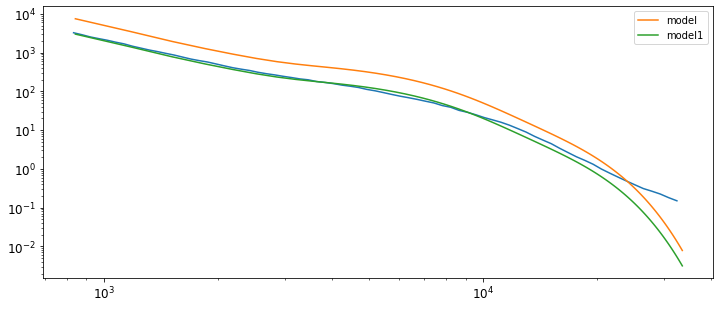

In [151]:
plt.figure(figsize=(12,5))
plt.plot(r_star, rho_stars)
plt.plot(radii_pc, d, label="model")
plt.plot(radii_pc, d1, label="model1")

plt.legend()
plt.loglog()